<a href="https://colab.research.google.com/github/onurertekin/MultilayerPerceptron/blob/main/Multilayerperceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0 | Train Loss: 0.408889 | Val Loss: 0.351185 | Test Loss: 0.428104 | Train Acc: 0.825879 | Val Acc: 0.878981 | Test Acc:0.812176
Epoch 10 | Train Loss: 0.165610 | Val Loss: 0.181293 | Test Loss: 0.171210 | Train Acc: 0.947284 | Val Acc: 0.923567 | Test Acc:0.932642
Epoch 20 | Train Loss: 0.097598 | Val Loss: 0.159908 | Test Loss: 0.139262 | Train Acc: 0.963259 | Val Acc: 0.933121 | Test Acc:0.952073
Epoch 30 | Train Loss: 0.065884 | Val Loss: 0.159027 | Test Loss: 0.134446 | Train Acc: 0.978435 | Val Acc: 0.952229 | Test Acc:0.950777


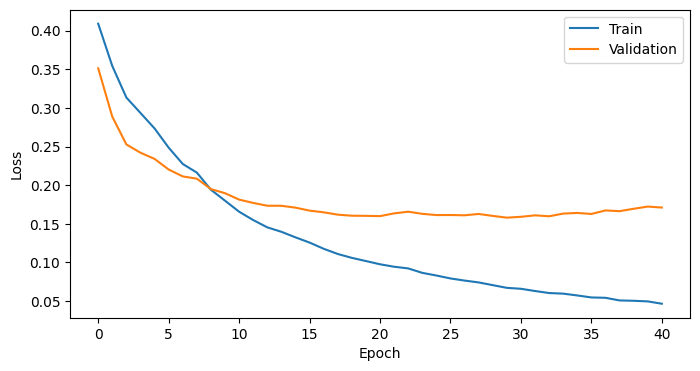

Train:
F1 Score: 0.98615 | Recall: 0.98055 | Precision: 0.99180
Test:
F1 Score: 0.94180 |  Recall: 0.91753 | Precision: 0.96739
Val:
F1 Score: 0.94118 | Recall: 0.92308 | Precision: 0.96000
Kodun çalışma süresi: 2.576775074005127 saniye


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import torch.utils.data as data
import time
start_time = time.time()
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 50)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x



class PrincessDataset(data.Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.inputs = torch.tensor(self.data.drop("Cured", axis=1).values, dtype=torch.float32)
        self.targets = torch.tensor(self.data["Cured"].values, dtype=torch.float32)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

    def __len__(self):
        return len(self.data)


train_data = PrincessDataset("sample_data/cure_the_princess_train.csv")
test_data = PrincessDataset("sample_data/cure_the_princess_test.csv")
val_data = PrincessDataset("sample_data/cure_the_princess_validation.csv")



model = MLP()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
torch.manual_seed(190401087)


train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []
train_inputs = train_data.inputs
train_targets = train_data.targets
val_inputs = val_data.inputs
val_targets = val_data.targets
test_inputs = test_data.inputs
test_targets = test_data.targets
num_epochs = 50
batch_size = 16
min_val_loss = float('inf')
patience = 0
early_stop_patience = 10

for epoch in range(num_epochs):
    for i in range(0, len(train_inputs), batch_size):
        batch_inputs = train_inputs[i:i+batch_size]
        batch_targets = train_targets[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_inputs).squeeze()
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()


    with torch.no_grad():
        train_outputs = model(train_inputs).squeeze()
        train_loss = criterion(train_outputs, train_targets)
        train_losses.append(train_loss.item())
        train_acc = (train_outputs > 0.5).float().eq(train_targets).sum().item() / len(train_targets)
        train_accs.append(train_acc)

        val_outputs = model(val_inputs).squeeze()
        val_loss = criterion(val_outputs, val_targets)
        val_losses.append(val_loss.item())
        val_acc = (val_outputs > 0.5).float().eq(val_targets).sum().item() / len(val_targets)
        val_accs.append(val_acc)

        test_outputs = model(test_inputs).squeeze()
        test_loss = criterion(test_outputs, test_targets)
        test_losses.append(test_loss.item())
        test_acc = (test_outputs > 0.5).float().eq(test_targets).sum().item() / len(test_targets)
        test_accs.append(test_acc)



        if val_loss < min_val_loss:
          min_val_loss = val_loss
          patience = 0
        else:
          patience += 1
        if patience > early_stop_patience:
            break


        if epoch % 10 == 0:
          print(f"Epoch {epoch} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Test Loss: {test_loss:.6f} | Train Acc: {train_acc:.6f} | Val Acc: {val_acc:.6f} | Test Acc:{test_acc:.6f}")


plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


with torch.no_grad():

    train_outputs = model(train_inputs).squeeze()
    train_preds = (train_outputs > 0.5).float()
    train_tp = ((train_preds == 1) & (train_targets == 1)).sum().item()
    train_tn = ((train_preds == 0) & (train_targets == 0)).sum().item()
    train_fp = ((train_preds == 1) & (train_targets == 0)).sum().item()
    train_fn = ((train_preds == 0) & (train_targets == 1)).sum().item()


    val_outputs = model(val_inputs).squeeze()
    val_preds = (val_outputs > 0.5).float()
    val_tp = ((val_preds == 1) & (val_targets == 1)).sum().item()
    val_tn = ((val_preds == 0) & (val_targets == 0)).sum().item()
    val_fp = ((val_preds == 1) & (val_targets == 0)).sum().item()
    val_fn = ((val_preds == 0) & (val_targets == 1)).sum().item()


    test_outputs = model(test_inputs).squeeze()
    test_preds = (test_outputs > 0.5).float()
    test_tp = ((test_preds == 1) & (test_targets == 1)).sum().item()
    test_tn = ((test_preds == 0) & (test_targets == 0)).sum().item()
    test_fp = ((test_preds == 1) & (test_targets == 0)).sum().item()
    test_fn = ((test_preds == 0) & (test_targets == 1)).sum().item()

train_precision = train_tp / (train_tp + train_fp)
train_recall = train_tp / (train_tp + train_fn)
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)

val_precision = val_tp / (val_tp + val_fp)
val_recall = val_tp / (val_tp + val_fn)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

test_precision = test_tp / (test_tp + test_fp)
test_recall = test_tp / (test_tp + test_fn)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("Train:")
print(f"F1 Score: {train_f1:.5f} | Recall: {train_recall:.5f} | Precision: {train_precision:.5f}")
print("Test:")
print(f"F1 Score: {test_f1:.5f} |  Recall: {test_recall:.5f} | Precision: {test_precision:.5f}")
print("Val:")
print(f"F1 Score: {val_f1:.5f} | Recall: {val_recall:.5f} | Precision: {val_precision:.5f}")
end_time = time.time()
total_time = end_time - start_time

print("Kodun çalışma süresi:", total_time, "saniye")